## Modeling Using Prophet Model

In [3]:
# import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

import holidays
import itertools
from datetime import datetime, date, timedelta
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### Load Dataset

In [18]:
df = pd.read_csv('final.csv')
df.head()

,date,BEVERAGES,BREAD/BAKERY,CLEANING,DAIRY,DELI,GROCERY I,MEATS,PERSONAL CARE,POULTRY,PRODUCE
0,2015-01-01,3528.0,676.24000,850.0,875.0,357.08200,3125.000,479.767000,203.0,279.169980,105.0
1,2015-01-02,111353.0,29702.92898,83431.0,43474.0,20804.69500,245045.337,24370.203999,23581.0,26814.086005,756.0
2,2015-01-03,110296.0,29305.08506,83648.0,45711.0,20014.19500,242694.753,21044.533846,24531.0,24995.854050,595.0
3,2015-01-04,122463.0,38390.82610,92456.0,56921.0,22452.49399,281467.988,22198.505007,27428.0,27507.856975,272.0
4,2015-01-05,88624.0,29377.54303,76070.0,43653.0,15715.71800,225516.495,16451.880920,20566.0,20565.498000,72.0


In [19]:
df.shape

(956, 11)

In [20]:
# filter the data as data before 2015 is very inconsistent
df['date'] = pd.to_datetime(df['date'])
df = df[(df['date'] > pd.Timestamp('2014-12-31'))]
df_produce = df[['date', 'PRODUCE']].reset_index(drop=True)
df_produce.head()

,date,PRODUCE
0,2015-01-01,105.0
1,2015-01-02,756.0
2,2015-01-03,595.0
3,2015-01-04,272.0
4,2015-01-05,72.0


### Forecasting for feature PRODUCE

In [21]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

forecast_start_date = date(2017, 7, 1)
forecast_start_date = forecast_start_date.strftime('%Y-%m-%d')

# get data for Category Product
df_produce_copy = df_produce.copy()
df_produce_copy = df_produce_copy.rename(columns={'date':'ds', feature:'y'})
df_produce_copy['y'] = pd.to_numeric(df_produce_copy['y'])

train_data = df_produce_copy[df_produce_copy['ds']<forecast_start_date]

Prophet is a forecasting algorithm that decomposes a time series into these main components:
* Trend: The overall direction of the data (upward, downward, or stable over time).
* Seasonality: Regular, periodic fluctuations that repeat (e.g., weekly, monthly, or yearly patterns).
* Holidays and Events: Special occasions or events that may affect the time series (e.g., holidays, sales events, or marketing campaigns)
* Error: The error term captures random noise or unpredictability in the data. Prophet assumes that errors follow a normal distribution

In [22]:
# Initialize the Prophet model
m = Prophet()

# Fit the model using the training data
m.fit(train_data)
future = m.make_future_dataframe(periods=prediction_days)
forecast = m.predict(future)

# Filter the forecasted data to include only the dates after the forecast start date
forecasted_dates_df = forecast[(forecast['ds'] >= forecast_start_date)]
predicted_df = forecasted_dates_df

df_produce_copy = df_produce_copy.rename(columns={'y':'ytrue'})
test_data = df_produce_copy[(df_produce_copy['ds']>=pd.to_datetime(forecast_start_date))]

# Merge the predicted values with the true data for evaluation
df_result = predicted_df.merge(test_data)
df_result.head()

12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ytrue
0,2017-07-01,132755.506025,129332.223356,178215.703564,132755.506025,132755.506025,19221.607350,19221.607350,19221.607350,9716.266649,9716.266649,9716.266649,9505.340701,9505.340701,9505.340701,0.0,0.0,0.0,151977.113376,155487.63090
1,2017-07-02,132793.871318,137371.573035,185302.086393,132793.871318,132793.871318,27459.891685,27459.891685,27459.891685,18352.558687,18352.558687,18352.558687,9107.332998,9107.332998,9107.332998,0.0,0.0,0.0,160253.763003,172890.13860
2,2017-07-03,132832.236610,109661.141698,157342.810221,132832.236610,132832.236610,799.544292,799.544292,799.544292,-7988.072190,-7988.072190,-7988.072190,8787.616481,8787.616481,8787.616481,0.0,0.0,0.0,133631.780902,130389.19902
3,2017-07-04,132870.601902,112930.670728,162150.398505,132870.601902,132870.601902,4423.907994,4423.907994,4423.907994,-4123.160617,-4123.160617,-4123.160617,8547.068610,8547.068610,8547.068610,0.0,0.0,0.0,137294.509896,131534.54802
4,2017-07-05,132908.967194,139988.505960,189320.097330,132908.967194,132908.967194,31442.429165,31442.429165,31442.429165,23058.445428,23058.445428,23058.445428,8383.983736,8383.983736,8383.983736,0.0,0.0,0.0,164351.396359,163804.33003


In [23]:
mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
print(f"MAPE: {mape:.4f}")  


MAPE: 0.1147


Changepoint_prior_scale: 
Controls the flexibility of the model in detecting trend changes (changepoints).
* A smaller value (e.g., 0.001 or 0.01) makes the trend less flexible. The model will resist fitting to abrupt changes in the trend, favoring smoother trends.
* A larger value (e.g., 0.1 or 0.5) allows more flexibility in detecting and fitting changepoints. The model can adapt to sudden shifts or fluctuations in the trend

Seasonality_prior_scale: 
Controls the flexibility of the model in fitting seasonal patterns.

* A smaller value (e.g., 0.01) results in smoother seasonal patterns. The model will avoid overfitting to small fluctuations in the data.
* A larger value (e.g., 1.0 or 10.0) allows the model to fit more complex and potentially noisier seasonal patterns

In [10]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Create a DataFrame of all combinations
param_combinations = pd.DataFrame([
    {'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps}
    for cps in param_grid['changepoint_prior_scale']
    for sps in param_grid['seasonality_prior_scale']
])

# Convert DataFrame rows to a list of dictionaries if needed
all_params = param_combinations.to_dict('records')
rmses = [] 
mapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_data)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mapes

11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:52 - cmdstanpy - INFO - Chain [1] done processing
11:57:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:58:46 - cmdstanpy - INFO - Chain [1] start processing
11:58:46 - cmdstanpy - INFO - Chain [1] done processing
11:58:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:58:47 - cmdstanpy - INFO - Chain [1] start processing
11:58:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:59:36 - cmdstanpy - INFO 

Lets use the best value of mape and rmse to train the PROPHET Model

Holidays often have a distinct impact on the data we are forecasting. Facebook Prophet is designed to work with time series data that has strong seasonal patterns, as well as with special events like holidays. The model can use holiday data to adjust its predictions and account for these variations. SARIMA is an extension of ARIMA that incorporates seasonality into the model. By adding holiday data as an external regressor, we can capture the effects of holidays on the time series.

In [11]:
#adding holiday data
holiday_df = pd.DataFrame([])

ecuador_holidays = holidays.EC() # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict

for date_, name in sorted(holidays.EC(years=[2015, 2016, 2017]).items()):
    holiday_df = pd.concat([holiday_df, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], format='%Y-%m-%d', errors='ignore')
holiday_df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_12116\1241628201.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


In [12]:
# Extract the best parameter values from the tuning results using minimum value of mape and rmse
params_dict = dict(tuning_results.sort_values(by=['mape', 'rmse']).reset_index(drop=True).drop('rmse', axis=1).iloc[0])

# Initialize the Prophet model with the best hyperparameters from tuning results
m = Prophet(changepoint_prior_scale = params_dict['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dict['seasonality_prior_scale'],
            holidays=holiday_df)

# Fit the Prophet model on the training data
m.fit(train_data)

# 'periods' specifies the number of days to forecast (45 days in this case)
future = m.make_future_dataframe(periods=45)
forecast = m.predict(future)

# Filter the forecasted data to include only dates after the forecast start date
predicted_df = forecast[(forecast['ds'] >= forecast_start_date)]
df_produce_copy = df_produce_copy.rename(columns={'y':'ytrue'})

# Merge the predicted values with the original data to include actual values for comparison
df_result = predicted_df.merge(df_produce_copy)
df_result.head()

12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,EC-Holidays,EC-Holidays_lower,EC-Holidays_upper,additive_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ytrue
0,2017-07-01,128347.526741,114037.972552,155716.766582,128347.526741,128347.526741,0.0,0.0,0.0,6351.131565,...,8213.837789,8213.837789,-1862.706223,-1862.706223,-1862.706223,0.0,0.0,0.0,134698.658306,155487.63090
1,2017-07-02,128347.918135,122722.706473,163348.250255,128347.918135,128347.918135,0.0,0.0,0.0,13914.830355,...,16243.335631,16243.335631,-2328.505276,-2328.505276,-2328.505276,0.0,0.0,0.0,142262.748490,172890.13860
2,2017-07-03,128348.309529,99300.188311,140719.808995,128348.309529,128348.309529,0.0,0.0,0.0,-9562.333884,...,-6872.234229,-6872.234229,-2690.099655,-2690.099655,-2690.099655,0.0,0.0,0.0,118785.975645,130389.19902
3,2017-07-04,128348.700923,100202.507188,144489.888201,128348.700923,128348.700923,0.0,0.0,0.0,-6594.915402,...,-3647.845360,-3647.845360,-2947.070042,-2947.070042,-2947.070042,0.0,0.0,0.0,121753.785521,131534.54802
4,2017-07-05,128349.092317,125336.306146,165312.038785,128349.092317,128349.092317,0.0,0.0,0.0,16925.380364,...,20026.951235,20026.951235,-3101.570870,-3101.570870,-3101.570870,0.0,0.0,0.0,145274.472681,163804.33003


In [13]:
mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
print(f"MAPE: {mape:.4f}")  # MAPE in fraction

MAPE: 0.0583


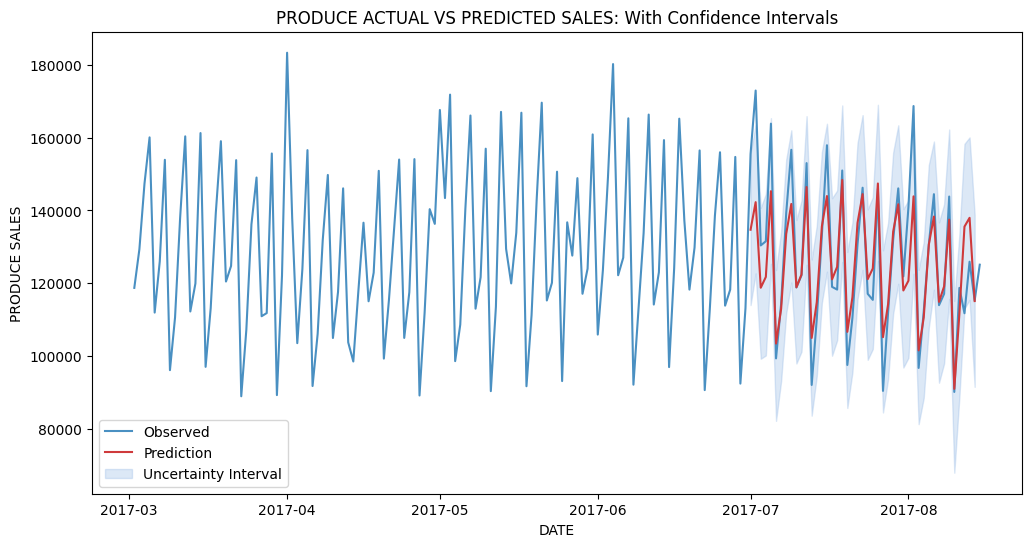

In [17]:
df_produce_copy = df_produce.copy()
df_produce_copy = df_produce_copy.rename(columns={'date': 'ds', feature: 'y'})

# Filter date to show in graph
df_produce_copy = df_produce_copy[(df_produce_copy['ds']>datetime(2017,3,1))]

# Plotting the graph
plt.figure(figsize=(12, 6))

# Plot past observed values with light dark blue 
plt.plot(df_produce_copy['ds'], df_produce_copy['y'], label='Observed', color='#4a90c2') 

# Plot predicted values with red 
plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Prediction', color='#cf3a3c', linestyle='-')  

# Add uncertainty intervals with a lighter shade of blue
plt.fill_between(predicted_df['ds'], 
                 predicted_df['yhat_lower'], 
                 predicted_df['yhat_upper'], 
                 color='#8CB3E3', 
                 alpha=0.3,
                 label='Uncertainty Interval')

# Adding labels, legend, and title
plt.xlabel('DATE')
plt.ylabel(f'{feature} SALES')
plt.title(f'{feature} ACTUAL VS PREDICTED SALES: With Confidence Intervals')
plt.legend()
plt.show()
